In [1]:
import pandas as pd
import numpy as np
import nltk
import re
pd.set_option('display.max_colwidth', -1)

## Get the Sentiment score as per the Sentences 

In [2]:
sentences=pd.read_csv("sentences_new.csv")

In [3]:
sentences.shape

(33, 2)

In [4]:
sentences.columns

Index(['text', 'score'], dtype='object')

In [5]:
sentences['score'].value_counts()

-1    12
 0    9 
-2    5 
 1    3 
-7    1 
-5    1 
-4    1 
 2    1 
Name: score, dtype: int64

In [6]:
target=[]
for i in sentences['score']:
    if i >=0:
        target.append(1)
    else:
        target.append(0)

In [7]:
sentences['target']=target

In [8]:
sentences['target'].value_counts()

0    20
1    13
Name: target, dtype: int64

In [9]:
df=sentences

In [10]:
df.head()

,text,score,target
0,POLÍTICA Y GOBIERNO La Cuarta Transformación ha implicado cambios sustantivos en materia legislativa que fortalecen a las instituciones de gobierno y la toma de decisiones del Ejecutivo Federal.,-1,0
1,"Sin duda, también ha requerido una intensa actividad jurídica que otorga certeza y transparencia a los asuntos del Gobierno Federal.",-1,0
2,"A la par, se ha garantizado la gobernabilidad con los tres órdenes de gobierno y se han encauzado nuevas formas de operación con el sector social.",0,1
3,"Algunas de ellas incluyen el privilegiar la defensa de los derechos humanos, formular acciones para mejorar la libertad religiosa y transformar a la Comisión Nacional para el Desarrollo de los Pueblos Indígenas en el nuevo Instituto Nacional de los Pueblos Indígenas.",1,1
4,"ERRADICAR LA CORRUPCIÓN, EL DISPENDIO Y LA FRIVOLIDAD",-1,0


## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, stratify = df.target, test_size = 0.3, random_state = 0)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer().fit(X_train)

In [14]:
X_train = tfidfVec.transform(X_train)
X_test = tfidfVec.transform(X_test)

## Model Building

### Multimonial Naive Bayes

In [16]:
df.target.value_counts()

0    20
1    13
Name: target, dtype: int64

In [17]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_auc_score, classification_report
MNB = MultinomialNB().fit(X_train, y_train)
y_pred = MNB.predict(X_test)

print("Statistics for classification are as follows: \n\n{}\n".format(classification_report(y_test, y_pred)))
print("ROC AUC Score {}".format(roc_auc_score(y_test, y_pred)))

Statistics for classification are as follows: 

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4

   micro avg       0.60      0.60      0.60        10
   macro avg       0.30      0.50      0.37        10
weighted avg       0.36      0.60      0.45        10


ROC AUC Score 0.5


C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

clfr = LogisticRegression(C = 100)
clfr.fit(X_train, y_train)

y_pred_proba = clfr.predict_proba(X_test)
y_prob = []
for i in y_pred_proba:
    y_prob.append(i[1])

fpr, tpr, thr = roc_curve(y_test, y_prob, pos_label = 1)

C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
ROC_AUC_DF = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thr})
ROC_AUC_DF['F1'] = 2 * (1 - ROC_AUC_DF.FPR) * ROC_AUC_DF.TPR / (ROC_AUC_DF.TPR + 1 - ROC_AUC_DF.FPR)
ROC_AUC_DF.head()

,FPR,TPR,Threshold,F1
0,0.000000,0.00,1.824139,0.000000
1,0.000000,0.25,0.824139,0.400000
2,0.000000,0.50,0.689471,0.666667
3,0.333333,0.50,0.299262,0.571429
4,0.333333,0.75,0.261394,0.705882


In [21]:
ROC_AUC_DF[ROC_AUC_DF.F1 == ROC_AUC_DF.F1.max()]

,FPR,TPR,Threshold,F1
4,0.333333,0.75,0.261394,0.705882


In [22]:
Thr = float(ROC_AUC_DF[ROC_AUC_DF.F1 == ROC_AUC_DF.F1.max()]['Threshold'])
Thr

0.261393952646951

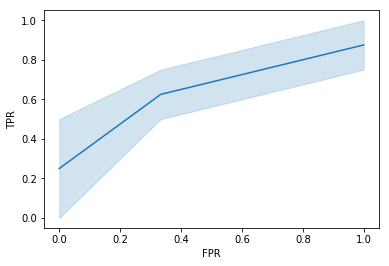

In [29]:
#rcParams['figure.figsize'] = 10, 7
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.lineplot(x = "FPR", y = "TPR",  data = ROC_AUC_DF)
plt.show()

In [30]:
y_pred_LR = []
for i in y_prob:
    if i >= Thr:
        y_pred_LR.append(1)
    else:
        y_pred_LR.append(0)

In [31]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.60      0.75      0.67         4

   micro avg       0.70      0.70      0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10



In [32]:
data=df

In [36]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(data.text, data.target, stratify = data.target, test_size = 0.3, random_state = 0)
indices = X_ts.index
pd.DataFrame({'Text':df['text'][indices], 'Prediction':y_pred_LR, 'Test':y_ts})

,Text,Prediction,Test
0,POLÍTICA Y GOBIERNO La Cuarta Transformación ha implicado cambios sustantivos en materia legislativa que fortalecen a las instituciones de gobierno y la toma de decisiones del Ejecutivo Federal.,0,0
25,• Se concluyeron 48 actos de fiscalización.,1,1
18,"De las acciones 1/ Disponible en el sitio: https://www.gob.mx/cms/uploads/attachment/file/455226/Gui_a_para_la_Elaboracio_n_del_Co_digo_de_Conducta_UEIPPIC-SFP.pdf.realizadas del 1 de diciembre de 2018 al 30 de junio de 2019 destacan las siguientes: • Se recibieron 20,504 denuncias por corrupción o faltas administrativas en toda la APF; se han concluido 3,536 investigaciones y permanecen abiertas 16,387.",0,0
22,"• Asimismo, se impusieron 1,736 sanciones a 1,426 servidores públicos.",0,1
19,Esto representa un incremento de 38% en el número de denuncias recibidas respecto al periodo comprendido entre diciembre de 2017 y junio de 2018.,1,0
24,"Además, hubo sanciones por incumplimiento de declaración patrimonial, violaciones al procedimiento de contratación y abuso de autoridad, entre otros.",0,0
16,"Entre el 1 de diciembre de 2018 y el 30 de junio de 2019, se han transferido a la SFP —a través de convenios entre las Unidades de Administración y Finanzas— los OIC de 13 secretarías de Estado.",1,1
23,"De ellas, 502 fueron inhabilitaciones, 103 destituciones, 123 sanciones económicas por un total de 674.4 millones de pesos, 353 suspensiones y 655 amonestaciones públicas y privadas, principalmente por negligencia administrativa.",1,0
30,"Entre el 1 de diciembre de 2018 y el 30 de junio de 2019, se determinaron: !2,723 observaciones sobre las cuales los gobiernos de los estados deben realizar los reintegros correspondientes por un monto de 20,206 millones de pesos.",1,1
5,El Gobierno de México tiene como una prioridad el combate a la corrupción y la impunidad.,0,0


## SMOTE 

### Multinomail Naive Bayes

In [39]:
import imblearn as imb
from imblearn.over_sampling import SMOTE
SMT = SMOTE()

X_t, y_t = SMT.fit_sample(X_train, y_train)

MNB = MultinomialNB().fit(X_t, y_t)
y_pred_SMOTE = MNB.predict(X_test)

print("Statistics for classification are as follows: \n\n{}\n".format(classification_report(y_test, y_pred_SMOTE)))
print("ROC AUC Score {}".format(roc_auc_score(y_test, y_pred_SMOTE)))

Statistics for classification are as follows: 

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.67      0.50      0.57         4

   micro avg       0.70      0.70      0.70        10
   macro avg       0.69      0.67      0.67        10
weighted avg       0.70      0.70      0.69        10


ROC AUC Score 0.6666666666666666


### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

clfr = LogisticRegression(C = 100)
clfr.fit(X_t, y_t)

y_pred_proba = clfr.predict_proba(X_test)
y_prob = []
for i in y_pred_proba:
    y_prob.append(i[1])

fpr, tpr, thr = roc_curve(y_test, y_prob, pos_label = 1)

C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
ROC_AUC_DF = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thr})
ROC_AUC_DF['F1'] = 2 * (1 - ROC_AUC_DF.FPR) * ROC_AUC_DF.TPR / (ROC_AUC_DF.TPR + 1 - ROC_AUC_DF.FPR)
ROC_AUC_DF.head()

,FPR,TPR,Threshold,F1
0,0.000000,0.00,1.854581,0.000000
1,0.000000,0.25,0.854581,0.400000
2,0.000000,0.50,0.728552,0.666667
3,0.333333,0.50,0.326451,0.571429
4,0.333333,0.75,0.283421,0.705882


In [42]:
ROC_AUC_DF[ROC_AUC_DF.F1 == ROC_AUC_DF.F1.max()]

,FPR,TPR,Threshold,F1
4,0.333333,0.75,0.283421,0.705882


C:\Users\sneha chikhalekar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


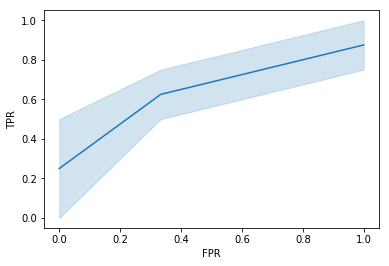

In [44]:
#rcParams['figure.figsize'] = 10, 7
sns.lineplot(x = "FPR", y = "TPR",  data = ROC_AUC_DF)
plt.show()

In [43]:
y_pred_SMOTE_LR = []
for i in y_prob:
    if i >= 0.2834:
        y_pred_SMOTE_LR.append(1)
    else:
        y_pred_SMOTE_LR.append(0)

In [45]:
print(classification_report(y_test, y_pred_SMOTE_LR))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.60      0.75      0.67         4

   micro avg       0.70      0.70      0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10



In [49]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(df.text, df.target, stratify = df.target, test_size = 0.3, random_state = 0)
indices = X_ts.index
pd.DataFrame({'Review':df['text'][indices], 'Prediction':y_pred_SMOTE_LR, 'Test':y_ts})

,Review,Prediction,Test
0,POLÍTICA Y GOBIERNO La Cuarta Transformación ha implicado cambios sustantivos en materia legislativa que fortalecen a las instituciones de gobierno y la toma de decisiones del Ejecutivo Federal.,0,0
25,• Se concluyeron 48 actos de fiscalización.,1,1
18,"De las acciones 1/ Disponible en el sitio: https://www.gob.mx/cms/uploads/attachment/file/455226/Gui_a_para_la_Elaboracio_n_del_Co_digo_de_Conducta_UEIPPIC-SFP.pdf.realizadas del 1 de diciembre de 2018 al 30 de junio de 2019 destacan las siguientes: • Se recibieron 20,504 denuncias por corrupción o faltas administrativas en toda la APF; se han concluido 3,536 investigaciones y permanecen abiertas 16,387.",0,0
22,"• Asimismo, se impusieron 1,736 sanciones a 1,426 servidores públicos.",0,1
19,Esto representa un incremento de 38% en el número de denuncias recibidas respecto al periodo comprendido entre diciembre de 2017 y junio de 2018.,1,0
24,"Además, hubo sanciones por incumplimiento de declaración patrimonial, violaciones al procedimiento de contratación y abuso de autoridad, entre otros.",0,0
16,"Entre el 1 de diciembre de 2018 y el 30 de junio de 2019, se han transferido a la SFP —a través de convenios entre las Unidades de Administración y Finanzas— los OIC de 13 secretarías de Estado.",1,1
23,"De ellas, 502 fueron inhabilitaciones, 103 destituciones, 123 sanciones económicas por un total de 674.4 millones de pesos, 353 suspensiones y 655 amonestaciones públicas y privadas, principalmente por negligencia administrativa.",1,0
30,"Entre el 1 de diciembre de 2018 y el 30 de junio de 2019, se determinaron: !2,723 observaciones sobre las cuales los gobiernos de los estados deben realizar los reintegros correspondientes por un monto de 20,206 millones de pesos.",1,1
5,El Gobierno de México tiene como una prioridad el combate a la corrupción y la impunidad.,0,0


Performance increases after SMOTING